In [ ]:
!apt-get update -y
!apt-get install -y --no-install-recommends openjdk-17-jdk-headless




Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,917 B in 1s (3,216 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar -xzf spark-3.5.1-bin-hadoop3.tgz
!mv spark-3.5.1-bin-hadoop3 /usr/local/spark


In [ ]:
!pip install -q pyspark==3.5.1 findspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/spark"

import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("TelecomProject") \
    .enableHiveSupport() \
    .getOrCreate()

spark


In [ ]:
!ls -lah /content


total 382M
drwxr-xr-x 1 root root 4.0K Nov 20 04:52 .
drwxr-xr-x 1 root root 4.0K Nov 20 03:34 ..
drwxr-xr-x 4 root root 4.0K Nov 17 14:29 .config
drwxr-xr-x 1 root root 4.0K Nov 17 14:29 sample_data
-rw-r--r-- 1 root root 382M Feb 15  2024 spark-3.5.1-bin-hadoop3.tgz


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [ ]:
df = spark.read.option("header", True).option("inferSchema", True).csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.show(5)
df.printSchema()
print("Rows:", df.count())


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.functions import rand, lit, when, expr, col, floor

SEED = 42

# Standardize customer ID column
if "customerID" in df.columns:
    df = df.withColumnRenamed("customerID", "CustomerID")


In [ ]:
#1. Create CallStart timestamp (random in last 180 days)

max_seconds = 180 * 24 * 3600
df = df.withColumn("rand_ts", rand(seed=SEED))
df = df.withColumn(
    "CallStart",
    F.from_unixtime(
        F.unix_timestamp(F.current_timestamp()) - floor(col("rand_ts") * max_seconds)
    ).cast("timestamp")
)

In [ ]:
# 2. Call Duration in seconds (0–600 seconds)

df = df.withColumn("CallDurationSec", (rand(seed=SEED+1) * 600).cast("double"))


In [ ]:
# 3. Data Usage per session (0–5000 MB)

df = df.withColumn("DataUsageMB", (rand(seed=SEED+2) * 5000).cast("double"))


In [ ]:
# 4. Assign Cell-Tower location


locations = ["Kathmandu","Pokhara","Biratnagar","Butwal","Chitwan","Dharan","Ilam","Dhangadhi"]

def random_location():
    return random.choice(locations)

from pyspark.sql.functions import udf
location_udf = udf(random_location, StringType())

df = df.withColumn("Location", location_udf())

In [ ]:
# 5. Service Plan

df = df.withColumn(
    "ServicePlan",
    when(col("MonthlyCharges") < 30, "basic")
    .when(col("MonthlyCharges") < 60, "standard")
    .otherwise("premium")
)


In [ ]:
# 6. Complaints (10% chance)

df = df.withColumn("Complaints", (rand(seed=SEED+4) > 0.9).cast("int"))


In [ ]:
# 7. Estimated cost

df = df.withColumn(
    "EstimatedMonthlyCost",
    (col("MonthlyCharges") * 0.4 + col("DataUsageMB") * 0.01).cast("double")
)

In [ ]:
# Cleanup
df = df.drop("rand_ts")

df.show(5, truncate=False)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+-------------------------+--------------+------------+-----+-------------------+------------------+------------------+--------+-----------+----------+--------------------+
|CustomerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Churn|CallStart          |CallDurationSec   |DataUsageMB       |Location|ServicePlan|Complaints|EstimatedMonthlyCost|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+-------

In [ ]:
from pyspark.sql.functions import col, when, sum as spark_sum, avg as spark_avg, count as spark_count, max as spark_max

# 1. Aggregate usage per customer
usage_agg = df.groupBy("CustomerID").agg(
    spark_sum("CallDurationSec").alias("total_call_duration"),
    spark_sum("DataUsageMB").alias("total_data_mb"),
    spark_avg("CallDurationSec").alias("avg_call_duration"),
    spark_count("*").alias("num_sessions"),
    spark_max("CallStart").alias("last_activity")
)

In [ ]:
 #2. Aggregate customer info (plan, complaints, churn, charges)
static_agg = df.groupBy("CustomerID").agg(
    F.first("ServicePlan").alias("ServicePlan"),
    F.sum("Complaints").alias("complaint_count"),
    F.first("MonthlyCharges").alias("MonthlyCharges"),
    F.first("EstimatedMonthlyCost").alias("EstimatedMonthlyCost"),
    F.max(when(col("Churn")=="Yes", 1).otherwise(0)).alias("label")  # churn label
)


In [ ]:
# 3. Join usage + static info
customers = usage_agg.join(static_agg, "CustomerID", "inner")

customers.show(10, truncate=False)
customers.printSchema()
print("Total Customers:", customers.count())

+----------+-------------------+------------------+------------------+------------+-------------------+-----------+---------------+--------------+--------------------+-----+
|CustomerID|total_call_duration|total_data_mb     |avg_call_duration |num_sessions|last_activity      |ServicePlan|complaint_count|MonthlyCharges|EstimatedMonthlyCost|label|
+----------+-------------------+------------------+------------------+------------+-------------------+-----------+---------------+--------------+--------------------+-----+
|0002-ORFBO|167.789735857695   |546.6378409923267 |167.789735857695  |1           |2025-09-14 20:23:11|premium    |0              |65.6          |31.706378409923264  |0    |
|0003-MKNFE|208.22614355444475 |3536.7082835324145|208.22614355444475|1           |2025-09-09 19:19:56|standard   |1              |59.9          |59.32708283532415   |0    |
|0004-TLHLJ|276.3037228244913  |1090.0634940813043|276.3037228244913 |1           |2025-06-28 11:33:18|premium    |1              

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Convert ServicePlan to numeric index
plan_indexer = StringIndexer(
    inputCol="ServicePlan",
    outputCol="ServicePlanIndex",
    handleInvalid="keep"
)


In [ ]:
# Select relevant feature columns
feature_cols = [
    "total_call_duration",
    "total_data_mb",
    "avg_call_duration",
    "num_sessions",
    "complaint_count",
    "MonthlyCharges",
    "EstimatedMonthlyCost",
    "ServicePlanIndex"
]

In [ ]:
# Assemble features into vector column
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="keep"
)


In [ ]:
# Create pipeline
pipeline = Pipeline(stages=[plan_indexer, assembler])

In [ ]:
# Fit and transform data
pipeline_model = pipeline.fit(customers)
ml_df = pipeline_model.transform(customers)

In [ ]:
# Select only features + label
final_ml_df = ml_df.select("CustomerID", "features", col("label").cast("double"))

final_ml_df.show(5, truncate=False)

+----------+---------------------------------------------------------------------------------------------+-----+
|CustomerID|features                                                                                     |label|
+----------+---------------------------------------------------------------------------------------------+-----+
|0002-ORFBO|[167.789735857695,546.6378409923267,167.789735857695,1.0,0.0,65.6,31.706378409923264,0.0]    |0.0  |
|0003-MKNFE|[208.22614355444475,3536.7082835324145,208.22614355444475,1.0,1.0,59.9,59.32708283532415,2.0]|0.0  |
|0004-TLHLJ|[276.3037228244913,1090.0634940813043,276.3037228244913,1.0,1.0,73.9,40.460634940813044,0.0] |1.0  |
|0011-IGKFF|[398.5652624758822,1192.8777496717125,398.5652624758822,1.0,1.0,98.0,51.12877749671713,0.0]  |1.0  |
|0013-EXCHZ|[587.2614408535239,875.2878918308637,587.2614408535239,1.0,0.0,83.9,42.31287891830864,0.0]   |1.0  |
+----------+------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col


# Train-test split

train_df, test_df = final_ml_df.randomSplit([0.8, 0.2], seed=42)


# Train RandomForest model

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=50,
    maxDepth=10,
    seed=42
)

rf_model = rf.fit(train_df)


# Predict on the test set

predictions = rf_model.transform(test_df)

predictions.select("CustomerID", "prediction", "probability").show(10, truncate=False)


# Model Evaluation

# AUC score
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="probability",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(predictions)

# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator_acc.evaluate(predictions)

print("====== Model Performance ======")
print(f"AUC (ROC): {auc:.4f}")
print(f"Accuracy : {accuracy:.4f}")


+----------+----------+----------------------------------------+
|CustomerID|prediction|probability                             |
+----------+----------+----------------------------------------+
|0004-TLHLJ|0.0       |[0.6662049753662181,0.33379502463378186]|
|0013-SMEOE|0.0       |[0.6741162143512588,0.32588378564874126]|
|0015-UOCOJ|0.0       |[0.6712244234822068,0.32877557651779316]|
|0019-EFAEP|0.0       |[0.6109701265641222,0.3890298734358778] |
|0023-HGHWL|0.0       |[0.8885453489093393,0.11145465109066066]|
|0030-FNXPP|0.0       |[0.8865784032587737,0.11342159674122637]|
|0042-RLHYP|0.0       |[0.9257299313668004,0.07427006863319968]|
|0057-QBUQH|0.0       |[0.883098563123717,0.11690143687628288] |
|0078-XZMHT|0.0       |[0.6369940180725373,0.36300598192746275]|
|0080-EMYVY|0.0       |[0.8803304676157029,0.1196695323842971] |
+----------+----------+----------------------------------------+
only showing top 10 rows

====== Model Performance ======
AUC (ROC): 0.6598
Accuracy : 0.7

In [ ]:
from pyspark.sql.functions import hour, col, sum as spark_sum, count as spark_count


# 1. Extract hour from CallStart timestamp

df_with_hour = df.withColumn("Hour", hour(col("CallStart")))


# 2. Aggregate sessions & data usage by Location + Hour

congestion = df_with_hour.groupBy("Location", "Hour").agg(
    spark_count("*").alias("num_sessions"),
    spark_sum("DataUsageMB").alias("total_data_mb")
)

congestion.orderBy(col("num_sessions").desc()).show(20, truncate=False)


+----------+----+------------+------------------+
|Location  |Hour|num_sessions|total_data_mb     |
+----------+----+------------+------------------+
|Chitwan   |19  |53          |138164.8043979472 |
|Kathmandu |11  |52          |145950.73730800184|
|Pokhara   |21  |49          |122060.15010198017|
|Butwal    |5   |49          |123519.95619124515|
|Kathmandu |1   |49          |102394.85829976373|
|Biratnagar|15  |48          |124452.42035402215|
|Butwal    |9   |48          |119980.79828070909|
|Butwal    |6   |47          |120863.74299753284|
|Dharan    |7   |47          |118310.14407266953|
|Chitwan   |2   |47          |110012.74639956484|
|Dharan    |11  |45          |95541.58462892917 |
|Ilam      |5   |45          |116444.67170029983|
|Ilam      |21  |45          |121334.40346862494|
|Biratnagar|12  |45          |90324.5725738967  |
|Chitwan   |11  |45          |107031.26951964298|
|Chitwan   |13  |44          |101422.40577542018|
|Dhangadhi |8   |44          |131734.8575569684 |


Identify Peak Hours (18–21)

In [ ]:
peak_congestion = congestion.filter(
    (col("Hour") >= 18) & (col("Hour") <= 21)
).orderBy(col("num_sessions").desc())

peak_congestion.show(20, truncate=False)


+----------+----+------------+------------------+
|Location  |Hour|num_sessions|total_data_mb     |
+----------+----+------------+------------------+
|Biratnagar|18  |48          |131235.7897999142 |
|Dharan    |19  |47          |115829.89715439305|
|Ilam      |18  |45          |115097.54478810985|
|Dhangadhi |19  |45          |128184.1606761228 |
|Dharan    |18  |44          |99743.98218955308 |
|Kathmandu |19  |43          |110914.06819383301|
|Dharan    |20  |43          |98258.35144297722 |
|Dharan    |21  |42          |108039.02236543872|
|Butwal    |20  |42          |99552.60788698272 |
|Pokhara   |19  |41          |99236.35538514257 |
|Butwal    |21  |41          |105589.31208866382|
|Pokhara   |21  |40          |106995.11392646062|
|Chitwan   |18  |40          |101113.5090377459 |
|Biratnagar|21  |40          |92229.16603742521 |
|Chitwan   |19  |40          |101844.74771576938|
|Chitwan   |21  |39          |100570.7189894906 |
|Dhangadhi |21  |39          |79366.53180249684 |


Identify the most congested locations (all-day)

In [ ]:
top_locations = congestion.groupBy("Location").agg(
    spark_sum("num_sessions").alias("daily_sessions"),
    spark_sum("total_data_mb").alias("daily_data_mb")
).orderBy(col("daily_sessions").desc())

top_locations.show(10, truncate=False)


+----------+--------------+------------------+
|Location  |daily_sessions|daily_data_mb     |
+----------+--------------+------------------+
|Kathmandu |892           |2199740.3727051276|
|Chitwan   |888           |2161003.543849421 |
|Biratnagar|885           |2092816.0882495635|
|Pokhara   |882           |2221305.980220843 |
|Ilam      |880           |2166769.123837785 |
|Dharan    |879           |2197305.9201237797|
|Dhangadhi |871           |2169803.906218282 |
|Butwal    |866           |2272622.317021218 |
+----------+--------------+------------------+



In [ ]:
from pyspark.sql.functions import col, sum as spark_sum, count as spark_count


# 1. Monthly revenue is already derived from MonthlyCharges.
#    For telecom business modelling, define:
#       - Revenue = MonthlyCharges
#       - Cost = EstimatedMonthlyCost
#       - Profit = Revenue - Cost


customers_profit = customers.withColumn(
    "Revenue", col("MonthlyCharges").cast("double")
).withColumn(
    "Cost", col("EstimatedMonthlyCost").cast("double")
).withColumn(
    "Profit", (col("Revenue") - col("Cost")).cast("double")
)


# 2. Compute profitability per service plan


plan_profit = customers_profit.groupBy("ServicePlan").agg(
    spark_count("*").alias("num_customers"),
    spark_sum("Revenue").alias("total_revenue"),
    spark_sum("Cost").alias("total_cost"),
    spark_sum("Profit").alias("total_profit")
).orderBy(col("total_profit").desc())

plan_profit.show(truncate=False)


+-----------+-------------+------------------+------------------+-------------------+
|ServicePlan|num_customers|total_revenue     |total_cost        |total_profit       |
+-----------+-------------+------------------+------------------+-------------------+
|premium    |4136         |359641.6500000003 |246885.43359383327|112756.21640616698 |
|standard   |1254         |60929.59999999998 |55329.949472522145|5599.650527477779  |
|basic      |1653         |35545.349999999984|55044.929455904814|-19499.579455904823|
+-----------+-------------+------------------+------------------+-------------------+



In [ ]:
import time
from pyspark.sql.functions import sum as spark_sum
# DataFrame API Performance
start_df = time.time()

df_result_df = df.groupBy("Location") \
                 .agg(spark_sum("DataUsageMB").alias("total_data")) \
                 .collect()

time_df = time.time() - start_df



In [ ]:
# Spark SQL Performance
df.createOrReplaceTempView("cdr")

start_sql = time.time()

df_result_sql = spark.sql("""
    SELECT Location, SUM(DataUsageMB) AS total_data
    FROM cdr
    GROUP BY Location
""").collect()

time_sql = time.time() - start_sql

In [ ]:
# RDD API Performance

start_rdd = time.time()

df_result_rdd = df.rdd.map(lambda row: (row["Location"], float(row["DataUsageMB"]))) \
                      .reduceByKey(lambda a, b: a + b) \
                      .collect()

time_rdd = time.time() - start_rdd

In [ ]:
# Print performance comparison
print("===== PERFORMANCE RESULTS =====")
print(f"DataFrame API time : {time_df:.4f} seconds")
print(f"Spark SQL time     : {time_sql:.4f} seconds")
print(f"RDD API time       : {time_rdd:.4f} seconds")

print("\n===== SAMPLE OUTPUT (DataFrame) =====")
print(df_result_df[:5])

===== PERFORMANCE RESULTS =====
DataFrame API time : 0.5894 seconds
Spark SQL time     : 0.5068 seconds
RDD API time       : 2.8995 seconds

===== SAMPLE OUTPUT (DataFrame) =====
[Row(Location='Ilam', total_data=2225831.059238499), Row(Location='Pokhara', total_data=2210011.860272579), Row(Location='Dharan', total_data=2137191.536920267), Row(Location='Chitwan', total_data=2058881.4035695172), Row(Location='Kathmandu', total_data=2087406.8373085137)]


In [ ]:
# 1. Create a Hive database

spark.sql("CREATE DATABASE IF NOT EXISTS telecom_db")
spark.sql("USE telecom_db")

# 2. Save DataFrames as Hive tables

# Raw telecom CDR-like table
df.write.mode("overwrite").saveAsTable("telecom_cdr")

# Customer aggregated table
customers.write.mode("overwrite").saveAsTable("telecom_customers")

print("Hive tables created successfully!")

Hive tables created successfully!


In [ ]:
spark.sql("""
SELECT Location,
       COUNT(*) AS num_sessions,
       SUM(DataUsageMB) AS total_data_mb
FROM telecom_cdr
GROUP BY Location
ORDER BY num_sessions DESC
LIMIT 10
""").show(truncate=False)


+----------+------------+------------------+
|Location  |num_sessions|total_data_mb     |
+----------+------------+------------------+
|Pokhara   |918         |2276993.810035929 |
|Kathmandu |903         |2259436.926742649 |
|Chitwan   |901         |2240983.5977613525|
|Dhangadhi |899         |2235133.051317796 |
|Dharan    |890         |2189357.9253664077|
|Butwal    |866         |2218690.5417462983|
|Biratnagar|847         |2151504.695305077 |
|Ilam      |819         |1909266.7039505066|
+----------+------------+------------------+



In [ ]:
spark.sql("""
SELECT Location,
       HOUR(CallStart) AS Hour,
       COUNT(*) AS sessions,
       SUM(DataUsageMB) AS data_mb
FROM telecom_cdr
WHERE HOUR(CallStart) BETWEEN 18 AND 21
GROUP BY Location, HOUR(CallStart)
ORDER BY sessions DESC
""").show(truncate=False)


+----------+----+--------+------------------+
|Location  |Hour|sessions|data_mb           |
+----------+----+--------+------------------+
|Kathmandu |19  |48      |132357.38554479217|
|Pokhara   |21  |48      |109218.8505244785 |
|Chitwan   |18  |47      |119074.9780851246 |
|Pokhara   |19  |46      |111483.9695861517 |
|Kathmandu |18  |46      |125988.3513000413 |
|Chitwan   |19  |43      |104649.33458557942|
|Ilam      |19  |43      |100943.52107230443|
|Butwal    |18  |42      |109050.64947270988|
|Dharan    |18  |42      |110576.6027451491 |
|Biratnagar|21  |42      |101601.93889389666|
|Kathmandu |20  |42      |110837.938825155  |
|Ilam      |18  |41      |98820.94920797735 |
|Kathmandu |21  |41      |113616.45433622731|
|Dhangadhi |19  |40      |91295.6428772448  |
|Chitwan   |20  |40      |106723.9079008273 |
|Dharan    |20  |40      |93113.48878170528 |
|Butwal    |20  |39      |92344.38632136639 |
|Butwal    |19  |38      |102535.54847450664|
|Dharan    |21  |38      |95545.93

In [ ]:
spark.sql("""
SELECT ServicePlan,
       SUM(MonthlyCharges) AS total_revenue,
       SUM(EstimatedMonthlyCost) AS total_cost,
       SUM(MonthlyCharges - EstimatedMonthlyCost) AS total_profit,
       COUNT(*) AS subscribers
FROM telecom_customers
GROUP BY ServicePlan
ORDER BY total_profit DESC
""").show(truncate=False)


+-----------+------------------+------------------+-------------------+-----------+
|ServicePlan|total_revenue     |total_cost        |total_profit       |subscribers|
+-----------+------------------+------------------+-------------------+-----------+
|premium    |359641.6500000003 |246885.43359383327|112756.21640616698 |4136       |
|standard   |60929.59999999998 |55329.949472522145|5599.650527477779  |1254       |
|basic      |35545.349999999984|55044.929455904814|-19499.579455904823|1653       |
+-----------+------------------+------------------+-------------------+-----------+



In [ ]:
spark.sql("""
SELECT ServicePlan,
       SUM(CASE WHEN label = 1 THEN 1 ELSE 0 END) AS churners,
       COUNT(*) AS total_customers,
       (SUM(CASE WHEN label = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS churn_rate
FROM telecom_customers
GROUP BY ServicePlan
ORDER BY churn_rate DESC
""").show(truncate=False)


+-----------+--------+---------------+-----------------+
|ServicePlan|churners|total_customers|churn_rate       |
+-----------+--------+---------------+-----------------+
|premium    |1380    |4136           |33.36557059961315|
|standard   |327     |1254           |26.07655502392344|
|basic      |162     |1653           |9.80036297640653 |
+-----------+--------+---------------+-----------------+



In [ ]:
spark.sql("""
SELECT ServicePlan,
       SUM(CASE WHEN label = 1 THEN 1 ELSE 0 END) AS churners,
       COUNT(*) AS total_customers,
       (SUM(CASE WHEN label = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS churn_rate
FROM telecom_customers
GROUP BY ServicePlan
ORDER BY churn_rate DESC
""").show(truncate=False)


+-----------+--------+---------------+-----------------+
|ServicePlan|churners|total_customers|churn_rate       |
+-----------+--------+---------------+-----------------+
|premium    |1380    |4136           |33.36557059961315|
|standard   |327     |1254           |26.07655502392344|
|basic      |162     |1653           |9.80036297640653 |
+-----------+--------+---------------+-----------------+



In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType


# 1. Define UDF function in Python

def risk_score(total_call_duration, complaint_count, num_sessions):
    # Handle possible null values
    total_call_duration = total_call_duration or 0
    complaint_count = complaint_count or 0
    num_sessions = num_sessions or 0

    # Simple interpretable telecom churn risk formula
    score = (0.5 * complaint_count) + \
            (0.3 * (1 / (1 + total_call_duration))) + \
            (0.2 * (1 / (1 + num_sessions)))

    return float(score)


# 2. Register UDF with Spark so Hive SQL can use it

spark.udf.register("risk_score_udf", risk_score, DoubleType())

print("UDF registered successfully!")


UDF registered successfully!


In [ ]:
from pyspark.sql.functions import udf

risk_score_udf = udf(risk_score, DoubleType())


In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType

# 1. Define risk score function
def risk_score(total_call_duration, complaint_count, num_sessions):
    total_call_duration = total_call_duration or 0
    complaint_count = complaint_count or 0
    num_sessions = num_sessions or 0

    score = (0.5 * complaint_count) + \
            (0.3 * (1 / (1 + total_call_duration))) + \
            (0.2 * (1 / (1 + num_sessions)))
    return float(score)

# 2. Register UDF for Hive SQL usage
spark.udf.register("risk_score_udf", risk_score, DoubleType())

# 3. Create UDF object for PySpark DataFrame usage
risk_score_udf = udf(risk_score, DoubleType())

# 4. Apply to your DataFrame
customers_with_risk = customers.withColumn(
    "risk_score",
    risk_score_udf(
        col("total_call_duration"),
        col("complaint_count"),
        col("num_sessions")
    )
)

customers_with_risk.select("CustomerID", "risk_score").show(10, truncate=False)


+----------+-------------------+
|CustomerID|risk_score         |
+----------+-------------------+
|3668-QPYBK|0.10197451887400556|
|6234-RAAPL|0.10056049968896204|
|1894-IGFSG|0.10066263909465803|
|6982-SSHFK|0.10070302085347622|
|5859-HZYLF|0.10166789238918282|
|6479-OAUSD|0.10119270753234713|
|2592-YKDIF|0.10086903612031828|
|6718-BDGHG|0.10061599065364184|
|3195-TQDZX|0.10051846902390431|
|4248-QPAVC|0.6020224094095388 |
+----------+-------------------+
only showing top 10 rows



In [ ]:
customers_with_risk.write.mode("overwrite").saveAsTable("telecom_customers_risk")


In [ ]:
spark.sql("""
SELECT
    CustomerID,
    risk_score_udf(total_call_duration, complaint_count, num_sessions) AS risk_score
FROM telecom_customers_risk
ORDER BY risk_score DESC
LIMIT 10
""").show(truncate=False)


+----------+------------------+
|CustomerID|risk_score        |
+----------+------------------+
|2737-YNGYW|0.7561166204512002|
|4648-YPBTM|0.7200899450190344|
|3932-IJWDZ|0.6886035933463482|
|9058-MJLZC|0.6734721934448361|
|5449-FIBXJ|0.6618643960627494|
|8316-BBQAY|0.650471824304431 |
|3069-SSVSN|0.6466340789391517|
|4625-EWPTF|0.6386825766550513|
|8085-MSNLK|0.6355828935369062|
|6161-UUUTA|0.633000667885195 |
+----------+------------------+



In [ ]:
spark.udf.register("risk_score_udf", risk_score, DoubleType())


<function __main__.risk_score(total_call_duration, complaint_count, num_sessions)>

In [ ]:
spark.sql("""
SELECT
    CustomerID,
    risk_score_udf(total_call_duration, complaint_count, num_sessions) AS risk_score
FROM telecom_customers_risk
ORDER BY risk_score DESC
LIMIT 10
""").show(truncate=False)


+----------+------------------+
|CustomerID|risk_score        |
+----------+------------------+
|2737-YNGYW|0.7561166204512002|
|4648-YPBTM|0.7200899450190344|
|3932-IJWDZ|0.6886035933463482|
|9058-MJLZC|0.6734721934448361|
|5449-FIBXJ|0.6618643960627494|
|8316-BBQAY|0.650471824304431 |
|3069-SSVSN|0.6466340789391517|
|4625-EWPTF|0.6386825766550513|
|8085-MSNLK|0.6355828935369062|
|6161-UUUTA|0.633000667885195 |
+----------+------------------+



In [ ]:
spark.sql("""
SELECT
    CustomerID,
    risk_score_udf(total_call_duration, complaint_count, num_sessions) AS risk_score
FROM telecom_customers_risk
ORDER BY risk_score DESC
LIMIT 10
""").show(truncate=False)



+----------+------------------+
|CustomerID|risk_score        |
+----------+------------------+
|2737-YNGYW|0.7561166204512002|
|4648-YPBTM|0.7200899450190344|
|3932-IJWDZ|0.6886035933463482|
|9058-MJLZC|0.6734721934448361|
|5449-FIBXJ|0.6618643960627494|
|8316-BBQAY|0.650471824304431 |
|3069-SSVSN|0.6466340789391517|
|4625-EWPTF|0.6386825766550513|
|8085-MSNLK|0.6355828935369062|
|6161-UUUTA|0.633000667885195 |
+----------+------------------+



In [ ]:
peak_congestion.printSchema()
peak_congestion.show(5)


root
 |-- Location: string (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- num_sessions: long (nullable = false)
 |-- total_data_mb: double (nullable = true)

+---------+----+------------+------------------+
| Location|Hour|num_sessions|     total_data_mb|
+---------+----+------------+------------------+
|   Dharan|  19|          51|148304.29395138926|
|Kathmandu|  20|          48|118092.10917677831|
|Dhangadhi|  19|          47|114372.72109144978|
|Kathmandu|  19|          46|125783.48645418177|
|Dhangadhi|  18|          45|117355.89937246201|
+---------+----+------------+------------------+
only showing top 5 rows



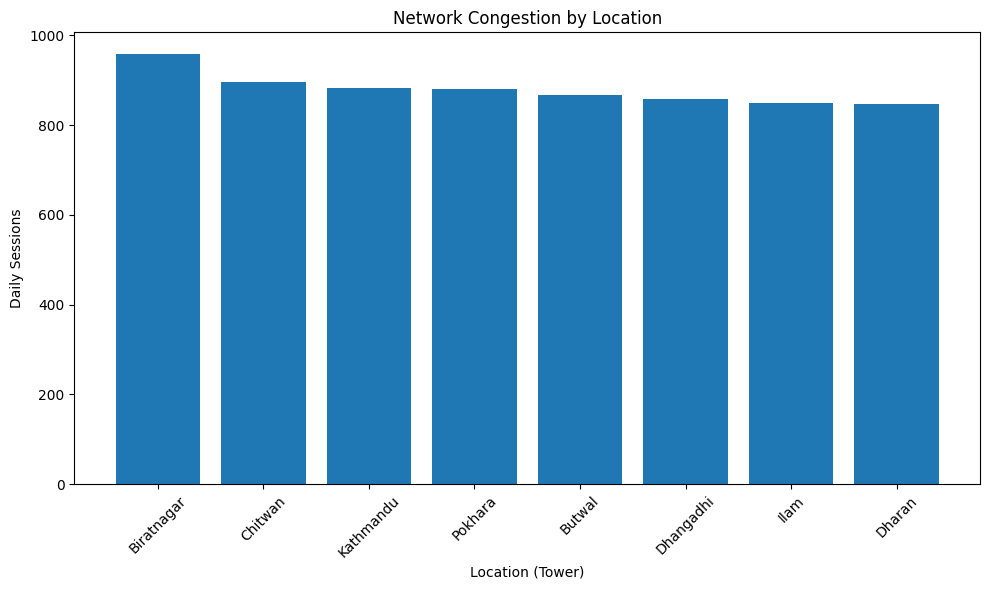

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark to Pandas
location_congestion_pd = top_locations.toPandas()

plt.figure(figsize=(10,6))
plt.bar(location_congestion_pd["Location"], location_congestion_pd["daily_sessions"])
plt.xlabel("Location (Tower)")
plt.ylabel("Daily Sessions")
plt.title("Network Congestion by Location")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


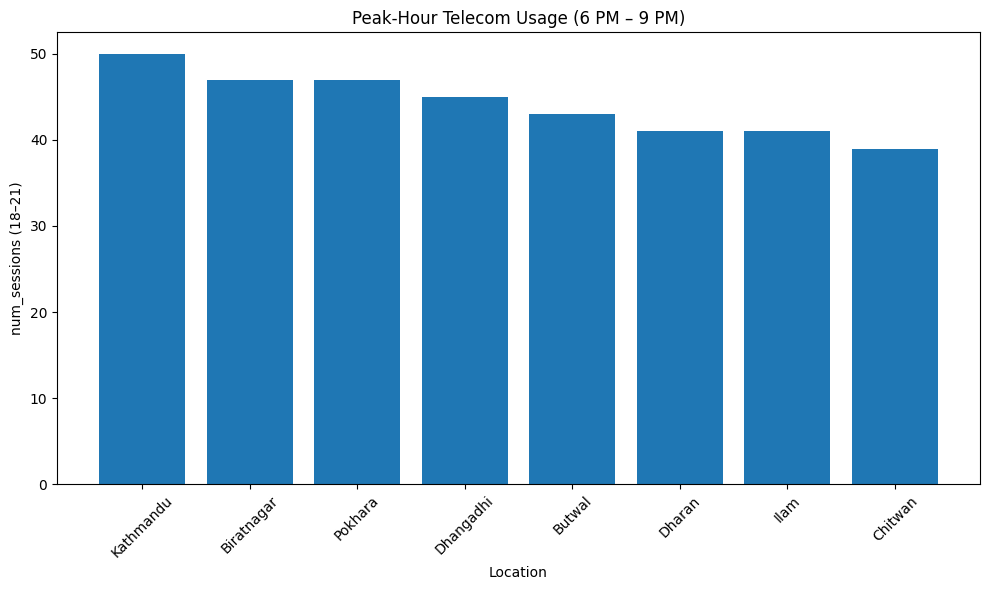

In [ ]:
peak_pd = peak_congestion.toPandas()

plt.figure(figsize=(10,6))
plt.bar(peak_pd["Location"], peak_pd["num_sessions"])
plt.xlabel("Location")
plt.ylabel("num_sessions (18–21)")
plt.title("Peak-Hour Telecom Usage (6 PM – 9 PM)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


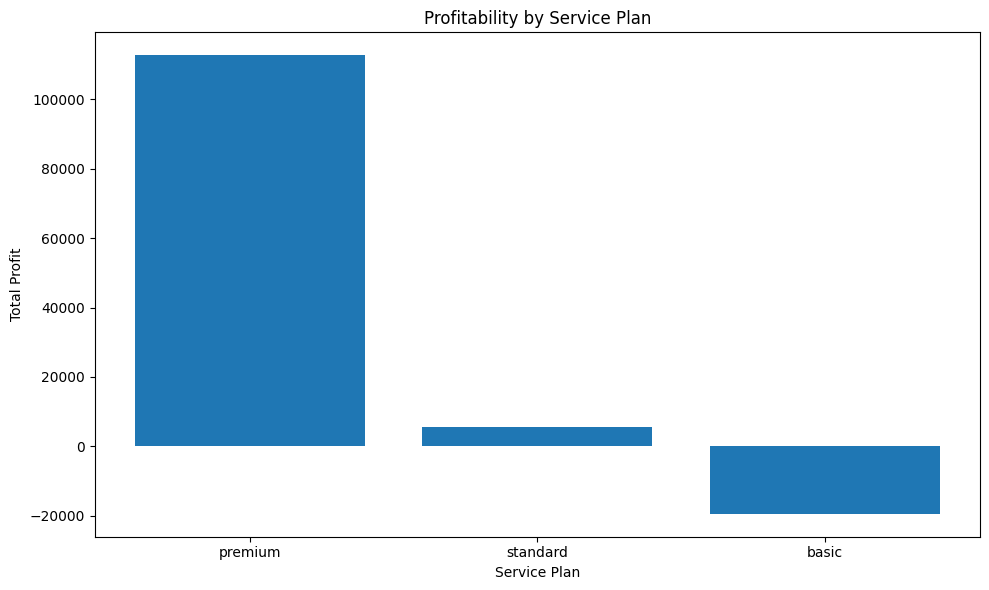

In [ ]:
profit_pd = plan_profit.toPandas()

plt.figure(figsize=(10,6))
plt.bar(profit_pd["ServicePlan"], profit_pd["total_profit"])
plt.xlabel("Service Plan")
plt.ylabel("Total Profit")
plt.title("Profitability by Service Plan")
plt.tight_layout()
plt.show()


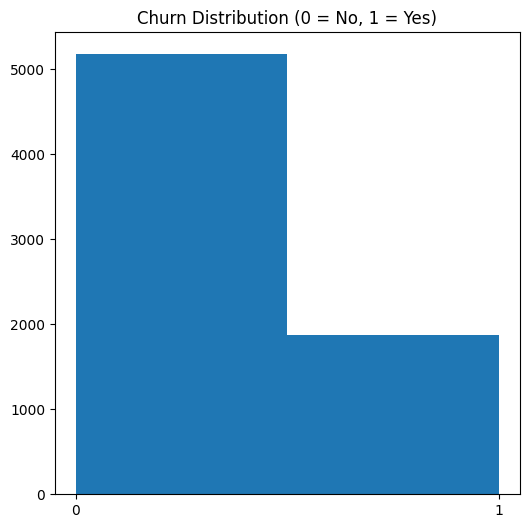

In [ ]:
churn_pd = customers.select("label").toPandas()

plt.figure(figsize=(6,6))
plt.hist(churn_pd["label"], bins=2)
plt.title("Churn Distribution (0 = No, 1 = Yes)")
plt.xticks([0,1])
plt.show()


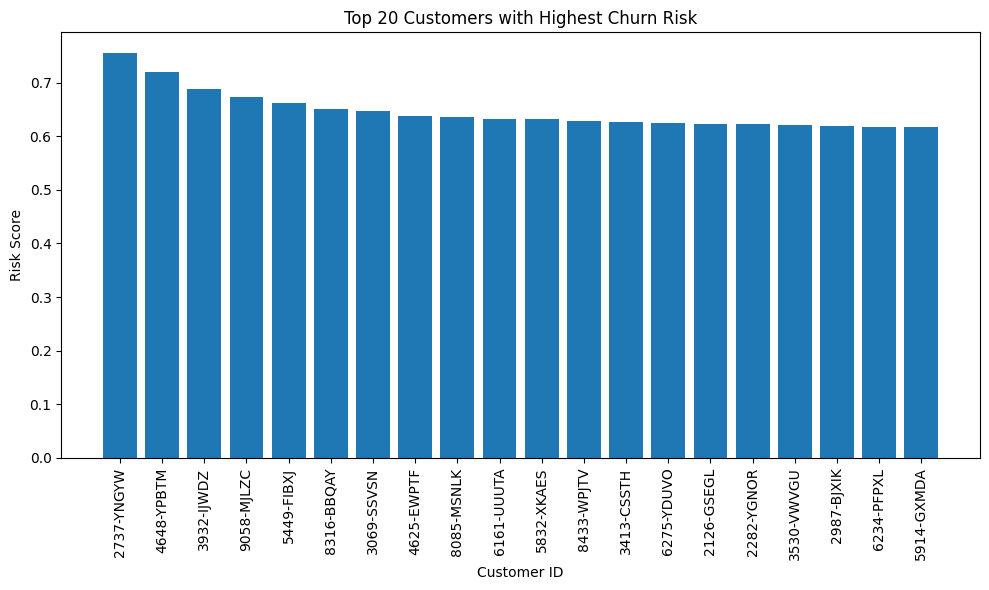

In [ ]:
risk_pd = customers_with_risk.orderBy(col("risk_score").desc()).limit(20).toPandas()

plt.figure(figsize=(10,6))
plt.bar(risk_pd["CustomerID"], risk_pd["risk_score"])
plt.xlabel("Customer ID")
plt.ylabel("Risk Score")
plt.title("Top 20 Customers with Highest Churn Risk")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType


In [ ]:
# For sparse vector struct, extract the second value (probability of class 1)
def get_prob(prob_struct):
    return float(prob_struct.values[1])

extract_prob_udf = udf(get_prob, DoubleType())


In [ ]:
predictions_fixed = predictions.withColumn("ChurnProb", extract_prob_udf(col("probability")))


In [ ]:
predictions_fixed.select("CustomerID", "prediction", "ChurnProb") \
    .write.mode("overwrite") \
    .option("header", True) \
    .csv("/mnt/data/output/telecom_predictions.csv")


In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType


# Save the processed DataFrame

df.write.mode("overwrite") \
    .option("header", True) \
    .csv("/mnt/data/output/telecom_processed.csv")

df.write.mode("overwrite") \
    .parquet("/mnt/data/output/telecom_processed.parquet")


#  Save predictions safely


# Define UDF to extract probability of class 1
def get_prob(prob_struct):
    # prob_struct.values is the array of probabilities
    return float(prob_struct.values[1])

extract_prob_udf = udf(get_prob, DoubleType())

# Add ChurnProb column
predictions_fixed = predictions.withColumn("ChurnProb", extract_prob_udf(col("probability")))

# Select only CSV-friendly columns
predictions_fixed.select("CustomerID", "prediction", "ChurnProb") \
    .write.mode("overwrite") \
    .option("header", True) \
    .csv("/mnt/data/output/telecom_predictions.csv")


#Optional: Save as Parquet for efficiency

predictions_fixed.select("CustomerID", "prediction", "ChurnProb") \
    .write.mode("overwrite") \
    .parquet("/mnt/data/output/telecom_predictions.parquet")

print("✅ All outputs saved successfully!")


✅ All outputs saved successfully!
